In [ ]:
# @title Check CUDA

## 1 Setup

In [ ]:
# @title 1.1 Install Dependencies
!pip install --upgrade "diffusers>=0.25.0" --quiet
# Global
import os
from glob import glob
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from tqdm.auto import tqdm
from PIL import Image
from matplotlib import cm
import requests
from google.colab import files
import time
# Marigold
!export HF_HOME=$(pwd)/checkpoint
from diffusers import DiffusionPipeline
from IPython.display import display
import ipywidgets as widgets
import shutil



# Depth Anything
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

#DPT
!pip install timm
import io


%matplotlib inline

In [ ]:
# @title 1.2 Setup Directories
repo_dir = "/content/MonoDepth"
input_dir = os.path.join(repo_dir, "input")
output_dir = os.path.join(repo_dir, "output")
output_Marigold = os.path.join(output_dir, "Marigold")
output_DA = os.path.join(output_dir, "Depth Anything")
output_DPT = os.path.join(output_dir, "DPT")


os.makedirs(repo_dir, exist_ok=True)
os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

os.chdir(repo_dir)

### Install and config models

In [ ]:
# @title 1.3.1 Marigold

Marigold = DiffusionPipeline.from_pretrained(
    "Bingxin/Marigold",
    custom_pipeline="marigold_depth_estimation"
)

Marigold = Marigold.to('cuda' if torch.cuda.is_available() else 'cpu')

def Marigold_estimate_depth(image,
                            denoising_steps = 10,
                            ensemble_size = 10,
                            processing_res = 768,
                            match_input_res = 'True'):
  match_input_res = (True if match_input_res == 'True' else False )
  with torch.no_grad():
    # Read input image
    image = Image.open(image).convert("RGB")

    # Predict depth
    predicted_depth = Marigold(
        image,
        denoising_steps=denoising_steps,     # optional
        ensemble_size=ensemble_size,       # optional
        processing_res=processing_res,     # optional
        match_input_res=match_input_res,   # optional
        batch_size=0,           # optional
        color_map="plasma_r",   # optional
        show_progress_bar=False, # optional
    )

    output: Image.Image = predicted_depth.depth_colored
    return output

In [ ]:
#@title 1.3.2 Depth Anything

#@markdown Select the type of model you want.
#@markdown - depth-anything-small: include 24.8M params
#@markdown - depth-anything-base: include 97.5M params
#@markdown - depth-anything-large: include 335.3M params
depth_anything_type = "large" #@param ["small", "base", "large"]

depth_anything_image_processor = AutoImageProcessor.from_pretrained(f"LiheYoung/depth-anything-{depth_anything_type}-hf")
depth_anything = AutoModelForDepthEstimation.from_pretrained(f"LiheYoung/depth-anything-{depth_anything_type}-hf")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
depth_anything.to(device)

def depth_anything_estimate_depth(image,
                                  match_input_res = 'True'):
  match_input_res = (True if match_input_res == 'True' else False )
  image = Image.open(image).convert("RGB")
  transformed_image = depth_anything_image_processor(images=image, return_tensors="pt").to(device)
  with torch.no_grad():
    outputs = depth_anything(**transformed_image)
    predicted_depth = outputs.predicted_depth

  if match_input_res:

    predicted_depth = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

  # visualize the prediction
  output = predicted_depth.squeeze().cpu().numpy()
  output = (output * 255 / np.max(output)).astype("uint8")
  cm_hot = cm.get_cmap('plasma')
  output = cm_hot(output)
  output = np.uint8(output * 255)
  output = Image.fromarray(output)
  return output

In [ ]:
#@title 1.3.3 DPT

#@markdown Select the type of model you want.
#@markdown - DPT_Large: highest accuracy, slowest inference speed.
#@markdown - DPT_Hybrid: medium accuracy, medium inference speed.
#@markdown - MiDaS_small: lowest accuracy, highest inference speed.
midas_type = "DPT_Hybrid" #@param ["DPT_Large", "DPT_Hybrid", "MiDaS_small"]

DPT = torch.hub.load("intel-isl/MiDaS", midas_type)
DPT_transform = torch.hub.load('intel-isl/MiDaS', 'transforms').dpt_transform

DPT.to(device)

def DPT_estimate_depth(image,
                       match_input_res = 'True'):
  image = np.array(Image.open(image).convert("RGB"))
  match_input_res = (True if match_input_res == 'True' else False )
  transformed_image = DPT_transform(image).to(device)

  with torch.no_grad():
      predicted_depth = DPT(transformed_image)

  if match_input_res:
    predicted_depth = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image.shape[:2],
        mode="bicubic",
        align_corners=False,
    )
  # print('a')
  output = predicted_depth.squeeze().cpu().numpy()
  output = (output * 255 / np.max(output)).astype("uint8")
  cm_hot = cm.get_cmap('plasma')
  output = cm_hot(output)
  output = np.uint8(output * 255)
  output = Image.fromarray(output)
  return output

In [ ]:
# @title Display output depth maps

def Display_maps(input_dir, output_dir):
  EXTENSION_LIST = [".jpg", ".jpeg", ".png"]

  # Image list
  rgb_filename_list = glob(os.path.join(input_dir, "*"))
  rgb_filename_list = [
      f for f in rgb_filename_list if os.path.splitext(f)[1].lower() in EXTENSION_LIST
  ]

  rgb_filename_list = sorted(rgb_filename_list)

  dirs = ['Input','DPT', 'Depth Anything', 'Marigold']

  figsize=(10, 2 * len(rgb_filename_list))
  nrows=len(rgb_filename_list)
  ncols=len(dirs)
  fig = plt.figure(figsize=(10, 2 * nrows))
  # add_headers(fig, dirs, row_headers=row_headers, **font_kwargs)

  i = 1;

  for rgb_path in rgb_filename_list:
    name_base = os.path.splitext(os.path.basename(rgb_path))[0]
    for depth_alg in dirs:

      if depth_alg == 'Input': im_path = rgb_path
      elif depth_alg == 'DPT':
        im_path = output_dir + '/' + depth_alg + '/' + name_base + '_DPT.png'
      elif depth_alg == 'Depth Anything':
        im_path = output_dir + '/' + depth_alg + '/' + name_base + '_depth_anything.png'
      elif depth_alg == 'Marigold':
        im_path = output_dir + '/' + depth_alg + '/' + name_base + '_Marigold.png'
      # print(im_path)
      # print(i)

      img = mpimg.imread(im_path)
      fig.add_subplot(nrows, ncols, i)
      if i<=4: plt.title(dirs[i-1])
      size = img.shape
      plt.imshow(img)
      # plt.axis('off')
      plt.xticks([])
      plt.yticks([])
      plt.xlabel(f"size: {size[1]}x{size[0]}")
      i+=1;
  plt.tight_layout()
  plt.show()

## 2 Models

In [ ]:
# @title 2.1 Prepare input data

button_download = widgets.Button(description="Use sample images")
button_upload = widgets.Button(description="⬆ Upload images")
button_clear_in = widgets.Button(description="♻ Clear input folder")
button_clear_out = widgets.Button(description="♻ Clear output folder")
out_box = widgets.Output()


def on_button_download_clicked(b):
    out_box.clear_output()
    os.makedirs(input_dir, exist_ok=True)
    os.chdir(input_dir)
    files = ['ants.jpg',  'bears.jpg',  'mountains.jpg',  'Night_city.jpg',  'people.jpeg'];
    exist = [f for f in files if os.path.isfile(f)];
    non_exist = list(set(exist) ^ set(files))
    os.chdir(input_dir)
    for sample_image in non_exist:
      if sample_image == 'people.jpeg':
        !gdown 1NmUNZLjtuzeR81LVz2YioXA9qjILNOl1 # people
      elif sample_image == 'Night_city.jpg':
        !gdown 14vYTAjdJha8G0h-1uxeCCLZes9GVC9J6 # Night_city
      elif sample_image == 'mountains.jpg':
        !gdown 1lxIrT1i9ZxlyStEzt5tVzO45h8vRFETd # mountains
      elif sample_image == 'bears.jpg':
        !gdown 1SWVYhSLBLyEwEuKs12gkDUU_5pY6a8FD # bears
      elif sample_image == 'ants.jpg':
        !gdown 13S6mxQJ0pkzSqfx20c44vPmZ55_wnACS # ants

    os.chdir(repo_dir)
    with out_box:
        print("sample images are downloaded")


def on_button_upload_clicked(b):
    out_box.clear_output()
    os.makedirs(input_dir, exist_ok=True)
    os.chdir(input_dir)
    with out_box:
        uploaded = files.upload()
    os.chdir(repo_dir)

def on_button_clear_in_clicked(b):
    out_box.clear_output()
    shutil.rmtree(input_dir)
    os.makedirs(input_dir)
    with out_box:
        print("Input images are cleared")

def on_button_clear_out_clicked(b):
    out_box.clear_output()
    shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    with out_box:
        print("Output folder is cleared")

button_download.on_click(on_button_download_clicked)
button_upload.on_click(on_button_upload_clicked)
button_clear_in.on_click(on_button_clear_in_clicked)
button_clear_out.on_click(on_button_clear_out_clicked)

widgets.VBox([widgets.HBox([button_upload, button_download]),
              widgets.HBox([button_clear_in, button_clear_out]),
              out_box])

In [ ]:
# @title 2.2 Run Models
#@markdown Global
match_input_res = "False" # @param ["False", "True"]
#@markdown Marigold
#@markdown - denoising_steps: Number of diffusion denoising steps (DDIM) during inference.
denoising_steps = 10 # @param {type:"integer"}
#@markdown - ensemble_size: Number of predictions to be ensembled.
ensemble_size = 10 # @param {type:"integer"}
#@markdown - ensemble_size: Maximum resolution of processing. If set to 0: will not resize at all.
processing_res = 768 # @param {type:"integer"}

EXTENSION_LIST = [".jpg", ".jpeg", ".png"]

# Image list
rgb_filename_list = glob(os.path.join(input_dir, "*"))
rgb_filename_list = [
    f for f in rgb_filename_list if os.path.splitext(f)[1].lower() in EXTENSION_LIST
]
rgb_filename_list = sorted(rgb_filename_list)

# Create output folders
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_Marigold, exist_ok=True)
os.makedirs(output_DA, exist_ok=True)
os.makedirs(output_DPT, exist_ok=True)

for rgb_path in tqdm(rgb_filename_list, desc=f"Estimating depth", leave=True):

    Marigold_depth_map: Image.Image = Marigold_estimate_depth(rgb_path)

    depth_anything_depth_map: Image.Image = depth_anything_estimate_depth(rgb_path, match_input_res)

    DPT_depth_map: Image.Image = DPT_estimate_depth(rgb_path, match_input_res)

    name_base = os.path.splitext(os.path.basename(rgb_path))[0]

    # Marigold
    Marigold_save_path = os.path.join(
        output_Marigold, f"{name_base}_Marigold.png"
    )
    if os.path.exists(Marigold_save_path):
        print(f"Existing file: '{Marigold_save_path}' will be overwritten")
    Marigold_depth_map.save(Marigold_save_path)

    # depth_anything
    depth_anything_save_path = os.path.join(
        output_DA, f"{name_base}_depth_anything.png"
    )
    if os.path.exists(depth_anything_save_path):
        print(f"Existing file: '{depth_anything_save_path}' will be overwritten")
    depth_anything_depth_map.save(depth_anything_save_path)

    # DPT
    DPT_save_path = os.path.join(
        output_DPT, f"{name_base}_DPT.png"
    )
    if os.path.exists(DPT_save_path):
        print(f"Existing file: '{DPT_save_path}' will be overwritten")
    DPT_depth_map.save(DPT_save_path)

Estimating depth:   0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-12-69b2fb87ed63>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm_hot = cm.get_cmap('plasma')
<ipython-input-15-dac1661d5afc>:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm_hot = cm.get_cmap('plasma')
<ipython-input-12-69b2fb87ed63>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm_hot = cm.get_cmap('plasma')
<ipython-input-15-dac1661d5afc>:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed t

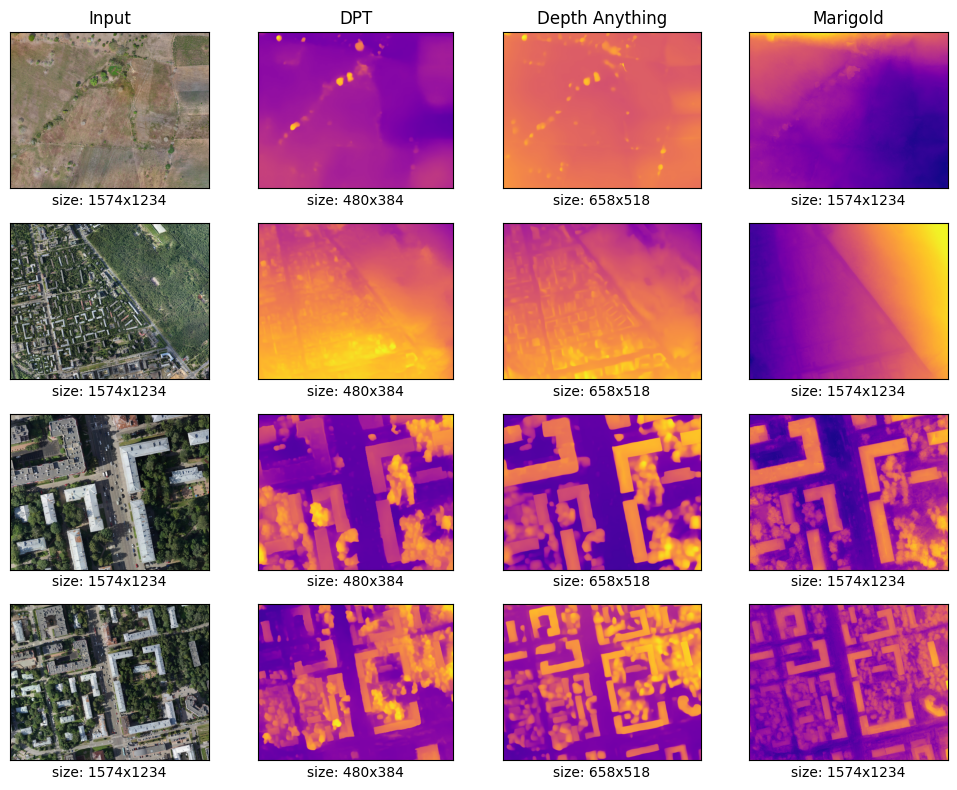

In [ ]:
# @title 2.3 display Depth maps
Display_maps(input_dir, output_dir)